In [1]:
pip install -U "transformers>=4.51.0" tokenizers

Defaulting to user installation because normal site-packages is not writeable


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 140.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 122.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 256.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [transformers] [transformers]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.21.0 requires pyarrow>=15.0.0, but you have pyarrow 14.0.1.dev0+gba5374836.d20240125 which is incompatible.
datasets 2.21.0 requires requests>=2.32.2, but you have requests 2.31.0 which is incompatible.
datasets 2.21.0 requires tqdm>=4.66.3, but you have tqdm 4.66.1 which is incompatible.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may

In [7]:
import os
import re
import json
import gc
import time
import math
import random
from dataclasses import dataclass
from collections import defaultdict
from fractions import Fraction
from typing import Dict, Any, Optional, List, Tuple

import subprocess
import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x, **kwargs: x  # fallback

In [ ]:
with open("/mnt/lts4/scratch/home/arahmani/rlad/RLAD/runs/gsmplus_1k_hints/selected_indices.json", "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            obj = json.loads(line)
            print(obj["row_idx"])
            break

In [42]:
data = np.hstack((np.array(d["indices"]).reshape((5000, 1)), np.array(ds[d["indices"]]["perturbation_type"]).reshape((5000, 1))))
data_frame = pd.DataFrame(data, columns=["row_idx", "perturbation_type"])
data_frame["row_idx"] = data_frame["row_idx"].astype(int)
data_frame["perturbation_type"] = data_frame["perturbation_type"].astype(str)

In [43]:
import pandas as pd

df1 = pd.read_json("/mnt/lts4/scratch/home/arahmani/rlad/RLAD/runs/gsmplus_1k_hints/cheatsheets_judged.jsonl", lines=True)
df1 = df1[["row_idx", "class"]]
df1

,row_idx,class
0,8813,productive_launchpoint
1,8808,productive_launchpoint
2,8814,structural_shortcut
3,8809,productive_launchpoint
4,8810,blind_follow_trajectory
...,...,...
4995,9821,productive_launchpoint
4996,9816,caution_alert
4997,9822,caution_alert
4998,9817,productive_launchpoint


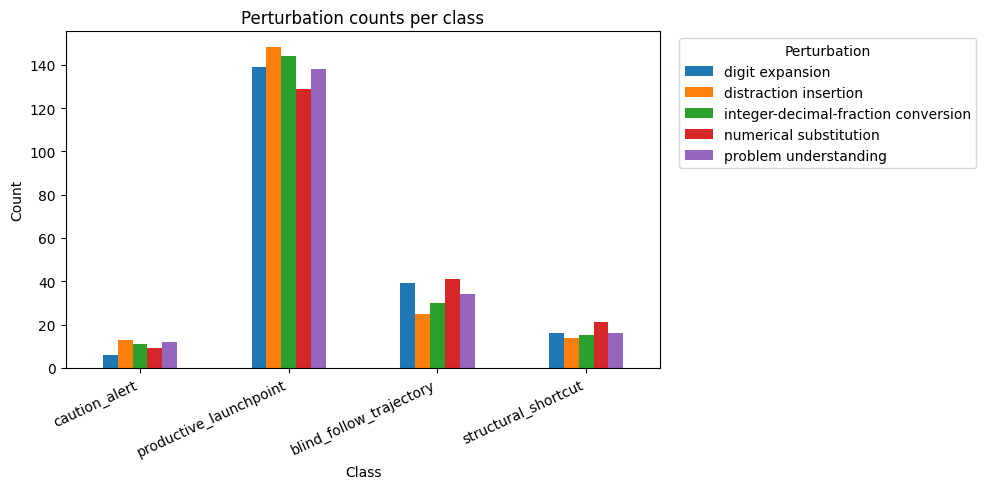

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# df columns assumed: ["row_idx", "class", "perturbation"]
# 1) counts table: rows=class, cols=perturbation, values=count
counts = (
    df.groupby(["class", "perturbation"])
      .size()
      .unstack(fill_value=0)
)

# Optional: order classes nicely
class_order = [
    "caution_alert",
    "productive_launchpoint",
    "blind_follow_trajectory",
    "structural_shortcut",
]
counts = counts.reindex([c for c in class_order if c in counts.index])

# 2) plot (grouped bars)
ax = counts.plot(kind="bar", figsize=(10, 5))  # grouped bars by default
ax.set_xlabel("Class")
ax.set_ylabel("Count")
ax.set_title("Perturbation counts per class")
ax.legend(title="Perturbation", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()


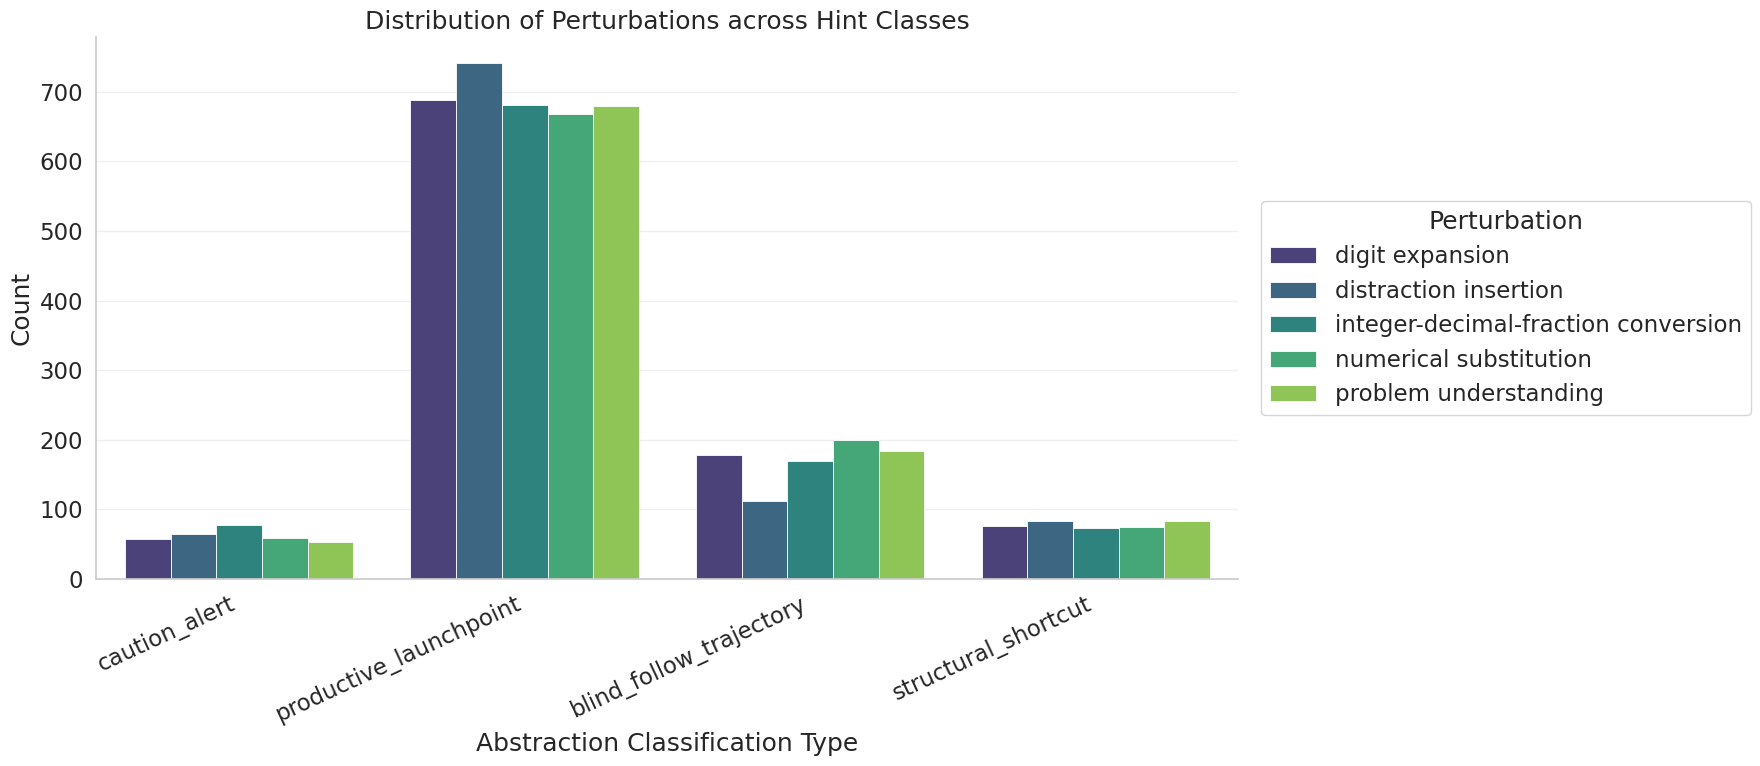

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# df columns: ["row_idx", "class", "perturbation"]

# 1) counts (long form)
counts = (
    df.groupby(["class", "perturbation"])
      .size()
      .reset_index(name="count")
)

# Optional: enforce class order
class_order = [
    "caution_alert",
    "productive_launchpoint",
    "blind_follow_trajectory",
    "structural_shortcut",
]
counts["class"] = pd.Categorical(counts["class"], categories=class_order, ordered=True)

# 2) seaborn style like your example
sns.set_theme(
    style="whitegrid",     # light horizontal grid
    context="notebook",    # similar text sizing
    font_scale=1.5
)

plt.figure(figsize=(18, 8))

ax = sns.barplot(
    data=counts,
    x="class",
    y="count",
    hue="perturbation",
    palette="viridis",     # similar blue→green family like the example
    dodge=True,
    edgecolor="white",
    linewidth=0.6
)

ax.set_xlabel("Abstraction Classification Type")
ax.set_ylabel("Count")
ax.set_title("Distribution of Perturbations across Hint Classes")

# Make grid/axes feel like the example
ax.grid(True, axis="y", alpha=0.3)
ax.grid(False, axis="x")
sns.despine(left=False, bottom=False)  # remove top/right spines

# Legend box on the right
ax.legend(
    title="Perturbation",
    frameon=True,
    bbox_to_anchor=(1.02, 0.5),
    loc="center left",
    borderaxespad=0.0
)

plt.xticks(rotation=25, ha="right")

plt.tight_layout()
plt.show()


In [44]:
df = df1.merge(data_frame, on="row_idx", how="inner").rename(columns={"perturbation_type": "perturbation"})
df

,row_idx,class,perturbation
0,8813,productive_launchpoint,problem understanding
1,8808,productive_launchpoint,numerical substitution
2,8814,structural_shortcut,distraction insertion
3,8809,productive_launchpoint,digit expansion
4,8810,blind_follow_trajectory,integer-decimal-fraction conversion
...,...,...,...
4995,9821,productive_launchpoint,problem understanding
4996,9816,caution_alert,numerical substitution
4997,9822,caution_alert,distraction insertion
4998,9817,productive_launchpoint,digit expansion


In [14]:
raw = f"[SYSTEM]\n{hs}\n\n[USER]\n{hu}\n\n[ASSISTANT]\n"
raw

"[SYSTEM]\nYou are a hint/abstraction generator for competition math.\nGiven a problem, write a CHEATSHEET of 3–6 short notes that help solve the problem.\nRules:\n- Do NOT reveal or compute the final numeric answer.\n- Prefer general procedures, identities, pitfalls, and checks.\n- Output ONLY the cheatsheet notes, no extra commentary.\n- Use the XML-ish format:\n  <note1><description>...</description><example>...</example></note1>\n  <note2>...</note2>\n\n\n[USER]\nPROBLEM:\nJanet’s ducks lay 20 eggs per day. She eats five for breakfast every morning and bakes muffins for her friends every day with six. She sells the remainder at the farmers' market daily for $3 per fresh duck egg. How much in dollars does she make every day at the farmers' market?\n\n[ASSISTANT]\n"

In [3]:
pipelines = [
    {
        "name": "baseline_non_rlad",
        "hint_model_id": os.getenv("BASE_HINT_ID", "Qwen/Qwen3-4B"),
        "solver_model_id": os.getenv("BASE_SOL_ID", "Qwen/Qwen3-1.7B"),
    },
    {
        "name": "rlad",
        "hint_model_id": os.getenv("RLAD_HINT_ID", "CMU-AIRe/RLAD-Hint-Gen"),
        "solver_model_id": os.getenv("RLAD_SOL_ID", "CMU-AIRe/RLAD-Sol-Gen"),
    },
]
unique_hint_ids = {p["hint_model_id"] for p in pipelines if p.get("hint_model_id")}

In [4]:
unique_hint_ids

{'CMU-AIRe/RLAD-Hint-Gen', 'Qwen/Qwen3-4B'}

In [8]:
# Load dataset
ds = load_dataset("qintongli/GSM-Plus", split="test")

Generating test split:   0%|          | 0/10552 [00:00<?, ? examples/s]

Generating testmini split:   0%|          | 0/2400 [00:00<?, ? examples/s]

In [10]:
def build_hint_prompt(problem: str) -> Tuple[str, str]:
    system = (
        "You are a hint/abstraction generator for competition math.\n"
        "Given a problem, write a CHEATSHEET of 3–6 short notes that help solve the problem.\n"
        "Rules:\n"
        "- Do NOT reveal or compute the final numeric answer.\n"
        "- Prefer general procedures, identities, pitfalls, and checks.\n"
        "- Output ONLY the cheatsheet notes, no extra commentary.\n"
        "- Use the XML-ish format:\n"
        "  <note1><description>...</description><example>...</example></note1>\n"
        "  <note2>...</note2>\n"
    )
    user = f"PROBLEM:\n{problem}"
    return system, user

In [19]:
with open("/mnt/lts4/scratch/home/arahmani/rlad/RLAD/runs/gsmplus_1k_hints/selected_indices.json", "r", encoding="utf-8") as f:
               d = json.load(f) 
                   

In [11]:

ex = ds[0]
question = (ex.get("question") or (ex.get("problem") or "")).strip()
hs, hu = build_hint_prompt(question)
#systems.append(hs)
#users.append(hu)
hs,hu

('You are a hint/abstraction generator for competition math.\nGiven a problem, write a CHEATSHEET of 3–6 short notes that help solve the problem.\nRules:\n- Do NOT reveal or compute the final numeric answer.\n- Prefer general procedures, identities, pitfalls, and checks.\n- Output ONLY the cheatsheet notes, no extra commentary.\n- Use the XML-ish format:\n  <note1><description>...</description><example>...</example></note1>\n  <note2>...</note2>\n',
 "PROBLEM:\nJanet’s ducks lay 20 eggs per day. She eats five for breakfast every morning and bakes muffins for her friends every day with six. She sells the remainder at the farmers' market daily for $3 per fresh duck egg. How much in dollars does she make every day at the farmers' market?")

In [10]:
gpu_before = sample_gpu_stats() 
gpu_before

NameError: name 'sample_gpu_stats' is not defined

In [ ]:
GSMPLUS_PERTURBATIONS = [
    "problem understanding",
    "numerical substitution",
    "distraction insertion",
    "digit expansion",
    "critical thinking",
    "adding operation",
    "integer-decimal-fraction conversion",
    "reversing operation",
]

DEFAULT_PIPELINES = [
    {
        "name": "baseline_non_rlad",
        "hint_model_id": os.getenv("BASE_HINT_ID", "Qwen/Qwen3-4B"),
        "solver_model_id": os.getenv("BASE_SOL_ID", "Qwen/Qwen3-1.7B"),
    },
    {
        "name": "rlad",
        "hint_model_id": os.getenv("RLAD_HINT_ID", "CMU-AIRe/RLAD-Hint-Gen"),
        "solver_model_id": os.getenv("RLAD_SOL_ID", "CMU-AIRe/RLAD-Sol-Gen"),
    },
]

# Choose perturbations
if "all".strip().lower() == "all":
        wanted_pts = set(GSMPLUS_PERTURBATIONS)
else:
        wanted_pts = set([p.strip() for p in args.perturbation_types.split(",") if p.strip()])

# Group indices by perturbation type
groups = group_indices_by_perturbation(ds)
selected_indices = []
rnd = random.Random(args.seed)
for pt in GSMPLUS_PERTURBATIONS:
        if pt not in wanted_pts:
            continue
        idxs = groups.get(pt, [])
        if args.max_per_type and args.max_per_type > 0 and len(idxs) > args.max_per_type:
            idxs = idxs[:]
            rnd.shuffle(idxs)
            idxs = idxs[: args.max_per_type]
        selected_indices.extend(idxs)

NameError: name 'GSMPLUS_PERTURBATIONS' is not defined

In [21]:
lili = ["a", "b", "c"]
b = [1, 2, 3]
lili.extend(b)
print(lili)

['a', 'b', 'c', 1, 2, 3]


In [ ]:
def group_indices_by_perturbation(dataset) -> Dict[str, List[int]]:
    groups = defaultdict(list)
    for i, ex in enumerate(dataset):
        pt = (ex.get("perturbation_type") or "").strip()
        groups[pt].append(i)
    return dict(groups)
groups = group_indices_by_perturbation(ds)

8

In [ ]:
import os
import re
import json
import gc
import time
import math
import random
from dataclasses import dataclass
from collections import defaultdict
from fractions import Fraction
from typing import Dict, Any, Optional, List, Tuple

import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x, **kwargs: x  # fallback


# -------------------- Defaults --------------------
GSMPLUS_PERTURBATIONS = [
    "problem understanding",
    "numerical substitution",
    "distraction insertion",
    "digit expansion",
    "critical thinking",
    "adding operation",
    "integer-decimal-fraction conversion",
    "reversing operation",
]

DEFAULT_PIPELINES = [
    {
        "name": "baseline_non_rlad",
        "hint_model_id": os.getenv("BASE_HINT_ID", "Qwen/Qwen3-4B"),
        "solver_model_id": os.getenv("BASE_SOL_ID", "Qwen/Qwen3-1.7B"),
    },
    {
        "name": "rlad",
        "hint_model_id": os.getenv("RLAD_HINT_ID", "CMU-AIRe/RLAD-Hint-Gen"),
        "solver_model_id": os.getenv("RLAD_SOL_ID", "CMU-AIRe/RLAD-Sol-Gen"),
    },
]


# -------------------- Utils --------------------
def torch_dtype(dtype_str: str):
    s = dtype_str.lower()
    if s in ("bf16", "bfloat16"):
        return torch.bfloat16
    if s in ("fp16", "float16"):
        return torch.float16
    if s in ("fp32", "float32"):
        return torch.float32
    raise ValueError(f"Unknown DTYPE={dtype_str}")


def chat_encode(tokenizer, system: str, user: str):
    if getattr(tokenizer, "chat_template", None):
        messages = [
            {"role": "system", "content": system.strip()},
            {"role": "user", "content": user.strip()},
        ]
        return tokenizer.apply_chat_template(
            messages, add_generation_prompt=True, return_tensors="pt"
        )
    raw = f"[SYSTEM]\n{system}\n\n[USER]\n{user}\n\n[ASSISTANT]\n"
    return tokenizer(raw, return_tensors="pt")["input_ids"]


def truncate_left(input_ids: torch.Tensor, keep_tokens: int):
    if input_ids.shape[-1] <= keep_tokens:
        return input_ids
    return input_ids[:, -keep_tokens:]


@torch.inference_mode()
def generate_text(
    model,
    tokenizer,
    system: str,
    user: str,
    max_context_tokens: int,
    max_new_tokens: int,
    do_sample: bool,
    temperature: float,
    top_p: float,
):
    input_ids = chat_encode(tokenizer, system=system, user=user)
    keep = max(1, max_context_tokens - max_new_tokens)
    input_ids = truncate_left(input_ids, keep_tokens=keep).to(model.device)

    gen_kwargs = dict(
        max_new_tokens=max_new_tokens,
        do_sample=do_sample,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
        use_cache=True,
    )
    if do_sample:
        gen_kwargs.update(dict(temperature=temperature, top_p=top_p))

    out = model.generate(input_ids, **gen_kwargs)
    gen = out[0, input_ids.shape[-1]:]
    return tokenizer.decode(gen, skip_special_tokens=True).strip()


def free_model(mdl, tok):
    del mdl
    del tok
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


def build_hint_prompt(problem: str) -> Tuple[str, str]:
    system = (
        "You are a hint/abstraction generator for competition math.\n"
        "Given a problem, write a CHEATSHEET of 3–6 short notes that help solve the problem.\n"
        "Rules:\n"
        "- Do NOT reveal or compute the final numeric answer.\n"
        "- Prefer general procedures, identities, pitfalls, and checks.\n"
        "- Output ONLY the cheatsheet notes, no extra commentary.\n"
        "- Use the XML-ish format:\n"
        "  <note1><description>...</description><example>...</example></note1>\n"
        "  <note2>...</note2>\n"
    )
    user = f"PROBLEM:\n{problem}"
    return system, user


def build_solver_prompt(problem: str, cheatsheet: str) -> Tuple[str, str]:
    system = (
        "You are an expert problem-solving assistant.\n"
        "Use the provided cheatsheet (if any) to solve the problem.\n"
        "Give the final answer in the exact form \\boxed{<answer>}.\n"
        "If the answer is a number, do not add units.\n"
    )
    user = f"CHEATSHEET:\n{cheatsheet}\n\nPROBLEM:\n{problem}\n"
    return system, user


_BOX_RE = re.compile(r"\\boxed\{([^}]*)\}")
_NUM_RE = re.compile(r"(-?\d[\d,]*\.?\d*(?:/\d[\d,]*\.?\d*)?)")


def _to_fraction(s: str) -> Optional[Fraction]:
    if s is None:
        return None
    t = s.strip()
    if not t:
        return None
    # common cleanup
    t = t.replace(",", "")
    # keep only the first token if there are trailing words
    # (still lets "150." or "150\n" work)
    t = t.strip()

    # Some models output like "#### 150"
    if t.startswith("####"):
        t = t[4:].strip()

    # If it's something like "150)" or "150." trim non-numeric tail
    m = _NUM_RE.search(t)
    if not m:
        return None
    token = m.group(1).replace(",", "")
    try:
        return Fraction(token)  # handles ints, decimals, simple fractions
    except Exception:
        return None


def extract_pred_answer(text: str) -> Optional[str]:
    if not text:
        return None
    m = _BOX_RE.search(text)
    if m:
        return m.group(1).strip()
    # fallback: last numeric-looking token
    ms = list(_NUM_RE.finditer(text))
    if ms:
        return ms[-1].group(1).strip()
    return None


def is_correct(pred_text: str, gt_text: str) -> Tuple[bool, Dict[str, Any]]:
    pred_raw = extract_pred_answer(pred_text)
    gt_raw = gt_text.strip() if gt_text is not None else ""

    pred_frac = _to_fraction(pred_raw) if pred_raw is not None else None
    gt_frac = _to_fraction(gt_raw)

    info = {
        "pred_raw": pred_raw,
        "gt_raw": gt_raw,
        "pred_frac": str(pred_frac) if pred_frac is not None else None,
        "gt_frac": str(gt_frac) if gt_frac is not None else None,
    }
    if pred_frac is None or gt_frac is None:
        return False, info
    return pred_frac == gt_frac, info


@dataclass
class GenConfig:
    dtype: str = os.getenv("DTYPE", "bfloat16")
    device_map: str = os.getenv("DEVICE_MAP", "auto")
    max_context_tokens: int = int(os.getenv("MAX_CONTEXT_TOKENS", "4096"))
    max_new_tokens_hint: int = int(os.getenv("MAX_NEW_TOKENS_HINT", "256"))
    max_new_tokens_sol: int = int(os.getenv("MAX_NEW_TOKENS_SOL", "512"))
    do_sample: bool = bool(int(os.getenv("DO_SAMPLE", "0")))
    temperature: float = float(os.getenv("TEMPERATURE", "0.7"))
    top_p: float = float(os.getenv("TOP_P", "0.9"))


def load_model_and_tokenizer(model_id: str, cfg: GenConfig):
    tok = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
    mdl = AutoModelForCausalLM.from_pretrained(
        model_id,
        torch_dtype=torch_dtype(cfg.dtype),
        device_map=cfg.device_map,
        trust_remote_code=True,
    )
    mdl.eval()
    return mdl, tok


def group_indices_by_perturbation(dataset) -> Dict[str, List[int]]:
    groups = defaultdict(list)
    for i, ex in enumerate(dataset):
        pt = (ex.get("perturbation_type") or "").strip()
        groups[pt].append(i)
    return dict(groups)


def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)


# -------------------- Main evaluation --------------------
def run_pipeline_on_indices(
    *,
    dataset,
    indices: List[int],
    pipeline: Dict[str, str],
    cfg: GenConfig,
    out_jsonl_path: str,
    resume: bool,
    seed: int,
):
    rnd = random.Random(seed)

    # Resume support: skip (pipeline_name, row_idx) already written
    done = set()
    if resume and os.path.exists(out_jsonl_path):
        with open(out_jsonl_path, "r", encoding="utf-8") as f:
            for line in f:
                try:
                    obj = json.loads(line)
                    done.add((obj.get("pipeline"), obj.get("row_idx")))
                except Exception:
                    pass

    # Load models ONCE per pipeline
    hint_model_id = pipeline["hint_model_id"]
    solver_model_id = pipeline["solver_model_id"]

    hint_model, hint_tok = load_model_and_tokenizer(hint_model_id, cfg)
    sol_model, sol_tok = load_model_and_tokenizer(solver_model_id, cfg)

    stats = {
        "n": 0,
        "correct": 0,
        "parse_fail": 0,
        "no_boxed": 0,
    }
    by_pt = defaultdict(lambda: {"n": 0, "correct": 0, "parse_fail": 0, "no_boxed": 0})

    with open(out_jsonl_path, "a", encoding="utf-8") as out_f:
        for row_idx in tqdm(indices, desc=f"{pipeline['name']}"):
            if (pipeline["name"], row_idx) in done:
                continue

            ex = dataset[row_idx]
            question = (ex.get("question") or ex.get("problem") or "").strip()
            gt = (ex.get("answer") or "").strip()
            pt = (ex.get("perturbation_type") or "").strip()
            seed_q = (ex.get("seed_question") or "").strip()

            # hint
            hs, hu = build_hint_prompt(question)
            try:
                cheatsheet = generate_text(
                    hint_model, hint_tok, hs, hu,
                    max_context_tokens=cfg.max_context_tokens,
                    max_new_tokens=cfg.max_new_tokens_hint,
                    do_sample=cfg.do_sample,
                    temperature=cfg.temperature,
                    top_p=cfg.top_p,
                )
            except torch.cuda.OutOfMemoryError:
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                cheatsheet = ""

            # solve
            ss, su = build_solver_prompt(question, cheatsheet)
            try:
                solver_out = generate_text(
                    sol_model, sol_tok, ss, su,
                    max_context_tokens=cfg.max_context_tokens,
                    max_new_tokens=cfg.max_new_tokens_sol,
                    do_sample=cfg.do_sample,
                    temperature=cfg.temperature,
                    top_p=cfg.top_p,
                )
            except torch.cuda.OutOfMemoryError:
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                solver_out = ""

            correct, info = is_correct(solver_out, gt)

            rec = {
                "ts": time.time(),
                "pipeline": pipeline["name"],
                "hint_model_id": hint_model_id,
                "solver_model_id": solver_model_id,
                "row_idx": row_idx,
                "perturbation_type": pt,
                "seed_question": seed_q,
                "question": question,
                "ground_truth_answer": gt,
                "cheatsheet": cheatsheet,
                "solver_output": solver_out,
                "pred_extracted": info["pred_raw"],
                "correct": correct,
                "debug_numeric": info,
            }
            out_f.write(json.dumps(rec, ensure_ascii=False) + "\n")
            out_f.flush()

            stats["n"] += 1
            by_pt[pt]["n"] += 1

            if info["pred_raw"] is None:
                stats["parse_fail"] += 1
                by_pt[pt]["parse_fail"] += 1
            if "\\boxed" not in (solver_out or ""):
                stats["no_boxed"] += 1
                by_pt[pt]["no_boxed"] += 1
            if correct:
                stats["correct"] += 1
                by_pt[pt]["correct"] += 1

    free_model(hint_model, hint_tok)
    free_model(sol_model, sol_tok)

    # compute accuracies
    def finalize(d):
        n = d["n"]
        d["acc"] = (d["correct"] / n) if n else 0.0
        return d

    stats = finalize(stats)
    by_pt = {k: finalize(v) for k, v in by_pt.items()}
    return stats, by_pt


def main():
    import argparse

    parser = argparse.ArgumentParser()
    parser.add_argument("--dataset_name", type=str, default="qintongli/GSM-Plus")
    parser.add_argument("--split", type=str, default="test")

    parser.add_argument(
        "--perturbation_types",
        type=str,
        default="all",
        help="Comma-separated list or 'all'.",
    )
    parser.add_argument(
        "--max_per_type",
        type=int,
        default=0,
        help="If >0, subsample this many examples per perturbation type.",
    )
    parser.add_argument("--seed", type=int, default=0)

    parser.add_argument("--out_dir", type=str, required=True)
    parser.add_argument("--resume", action="store_true")

    # optional: override pipelines via JSON
    parser.add_argument(
        "--pipelines_json",
        type=str,
        default="",
        help="Optional path to JSON list of pipelines: [{name,hint_model_id,solver_model_id}, ...]",
    )

    # generation overrides
    parser.add_argument("--dtype", type=str, default=os.getenv("DTYPE", "bfloat16"))
    parser.add_argument("--device_map", type=str, default=os.getenv("DEVICE_MAP", "auto"))
    parser.add_argument("--max_context_tokens", type=int, default=int(os.getenv("MAX_CONTEXT_TOKENS", "4096")))
    parser.add_argument("--max_new_tokens_hint", type=int, default=int(os.getenv("MAX_NEW_TOKENS_HINT", "2048")))
    parser.add_argument("--max_new_tokens_sol", type=int, default=int(os.getenv("MAX_NEW_TOKENS_SOL", "2048")))
    parser.add_argument("--do_sample", action="store_true")
    parser.add_argument("--temperature", type=float, default=float(os.getenv("TEMPERATURE", "0.7")))
    parser.add_argument("--top_p", type=float, default=float(os.getenv("TOP_P", "0.9")))

    args = parser.parse_args()

    ensure_dir(args.out_dir)
    records_path = os.path.join(args.out_dir, "records.jsonl")
    summary_path = os.path.join(args.out_dir, "summary.json")

    cfg = GenConfig(
        dtype=args.dtype,
        device_map=args.device_map,
        max_context_tokens=args.max_context_tokens,
        max_new_tokens_hint=args.max_new_tokens_hint,
        max_new_tokens_sol=args.max_new_tokens_sol,
        do_sample=args.do_sample,
        temperature=args.temperature,
        top_p=args.top_p,
    )

    # Load dataset
    ds = load_dataset(args.dataset_name, split=args.split)

    # Choose perturbations
    if args.perturbation_types.strip().lower() == "all":
        wanted_pts = set(GSMPLUS_PERTURBATIONS)
    else:
        wanted_pts = set([p.strip() for p in args.perturbation_types.split(",") if p.strip()])

    # Group indices by perturbation type
    groups = group_indices_by_perturbation(ds)
    selected_indices = []
    rnd = random.Random(args.seed)
    for pt in GSMPLUS_PERTURBATIONS:
        if pt not in wanted_pts:
            continue
        idxs = groups.get(pt, [])
        if args.max_per_type and args.max_per_type > 0 and len(idxs) > args.max_per_type:
            idxs = idxs[:]
            rnd.shuffle(idxs)
            idxs = idxs[: args.max_per_type]
        selected_indices.extend(idxs)

    # Pipelines
    if args.pipelines_json:
        with open(args.pipelines_json, "r", encoding="utf-8") as f:
            pipelines = json.load(f)
    else:
        pipelines = DEFAULT_PIPELINES

    # Run
    all_results = {
        "dataset": {"name": args.dataset_name, "split": args.split},
        "selected": {
            "perturbation_types": sorted(list(wanted_pts)),
            "max_per_type": args.max_per_type,
            "n_total": len(selected_indices),
        },
        "gen_cfg": cfg.__dict__,
        "pipelines": pipelines,
        "aggregate": {},
    }

    for pipe in pipelines:
        stats, by_pt = run_pipeline_on_indices(
            dataset=ds,
            indices=selected_indices,
            pipeline=pipe,
            cfg=cfg,
            out_jsonl_path=records_path,
            resume=args.resume,
            seed=args.seed,
        )
        all_results["aggregate"][pipe["name"]] = {
            "overall": stats,
            "by_perturbation_type": by_pt,
        }

        # Save summary after each pipeline (so you keep partial results if interrupted)
        with open(summary_path, "w", encoding="utf-8") as f:
            json.dump(all_results, f, indent=2, ensure_ascii=False)

    print(f"Wrote per-example logs: {records_path}")
    print(f"Wrote summary: {summary_path}")